In [1]:
!nvidia-smi

/usr/bin/sh: 1: nvidia-smi: not found


In [2]:
import tensorflow as tf

RESTRICT_GPU = False

if RESTRICT_GPU:
    gpus = tf.config.list_physical_devices('GPU')

    if gpus:
        # Restrict TensorFlow to only use a chosen GPU
        try:
            tf.config.set_visible_devices(gpus[1], 'GPU') # NB: I (Ferdinand) only use gpus[0], so gpus[1] should be free
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        except RuntimeError as e:
            # Visible devices must be set before GPUs have been initialized
            print(e)


2024-07-29 12:41:21.820520: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 12:41:21.854308: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 12:41:21.854338: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 12:41:21.854360: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 12:41:21.860771: I tensorflow/core/platform/cpu_feature_g

2 Physical GPUs, 1 Logical GPU


2024-07-29 12:41:23.798523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6


In [2]:
# From the git
import sys
sys.path.append('.')
sys.path.append('..')

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras import layers

from data.load_data import load_data
from utils.visualisation import get_color_map

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data

Load the Flumy dataset

In [4]:
# Useful constants

nb_categories = 4
image_size = (64, 128)

cmap, norm = get_color_map(number_of_categories=nb_categories)

facies_names = np.array(["Sand, Channel lag", "Sand, Point bar", "Silts, Levee", "Shale, Overbank"])

In [6]:
x = load_data(image_size[0], image_size[1], "../data/horizontal/dataFlumyHoriz.csv")
print(x.shape)

x_train = tf.cast(x[:2760], dtype=tf.float64)
x_test = tf.cast(x[2760:], dtype=tf.float64)

print(x_train.dtype)

(3000, 64, 128, 4)
<dtype: 'float64'>


## Q Matrix & Forward process Imports and Tests

In [7]:
from noising_markov_jump_process.noising_process import *

In [8]:
input_diffusion_times = np.ones((x_test.shape[0], 1, 1, 1), dtype=np.float64) * 0.999

def apply_forward(x0, t):
    return forward_process(x0, t, nb_categories)

modified_batch, _ = tf.map_fn(lambda x: apply_forward(x[0], x[1]), (x_test, input_diffusion_times))

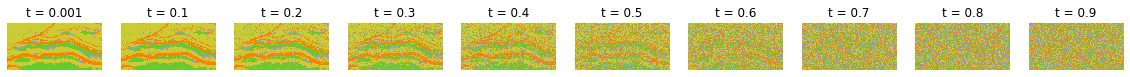

In [23]:
steps = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(20, 40))
for i, t in enumerate(steps):
    
    xt, _ = forward_process(x_test[5], tf.ones((1), dtype=tf.dtypes.float64) * t, nb_categories)

    plt.subplot(1, len(steps), i+1)
    plt.title("t = {}".format(t))
    plt.imshow(np.argmax(xt.numpy(), axis=-1).reshape((64, 128)),
                interpolation='nearest', cmap=cmap, norm=norm)
    plt.axis('off')
    
plt.show()

## Models

In [24]:
from models.ddm_mkj.diffusion_model import DiffusionModel

In [27]:
# create and compile the model
model = DiffusionModel(image_size,
                       categories_nb=nb_categories,
                       block_depth=2,
                       batch_size=30,
                       large_model=False)

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-5
    ),
    loss= tf.keras.losses.CategoricalCrossentropy(),
)

AttributeError: module 'tensorflow.keras.layers' has no attribute 'GroupNormalization'

In [28]:
load_model = False

weights_folder = "./trained_weights/4facies_ddm"

if load_model:
    model.network.load_weights(weights_folder + "*/unet/cp-unet_discrete_jump_markov.ckpt")
    model.ema_network.load_weights(weights_folder + "/ema_unet/cp-ema_unet_discrete_jump_markov.ckpt")
    model.load_weights("/ddm/cp-ddm_discrete_jump_markov.ckpt")

In [ ]:
train_model = True

if train_model:
    t_epochs_nb=650

    history = model.fit(x_train, batch_size=batch_size, shuffle=True, epochs=t_epochs_nb, validation_data=(x_test,))

Epoch 1/500


In [ ]:
if train_model:
    x_axis = np.arange(t_epochs_nb)
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, history.history["i_loss"], label="Training image CE loss")
    plt.plot(x_axis, history.history["val_i_loss"], label="Testing image CE loss")
    plt.legend(loc="upper left")
    plt.show()

In [ ]:
step_size = 0.01
steps = np.arange(0, 1, step_size, dtype=np.float64)
len(steps)

init_x = tf.random.uniform((1, 64, 128), 0, 4, dtype=tf.dtypes.int32)
init_x = keras.utils.to_categorical(init_x)
initial_noise, _ = forward_process(x_train[5], tf.reshape(steps[99], (1, 1, 1, 1)), 4) #init_x
plt.imshow(np.argmax(initial_noise, axis=-1).reshape((64, 128)),
            interpolation='nearest', cmap=cmap, norm=norm)
plt.show()
num_images = initial_noise.shape[0]

next_noisy_images = tf.expand_dims(initial_noise, axis=0)

for i, step in enumerate(np.flip(steps[:99])):
    print("i: {0}, step: {1}".format(i, step))
    noisy_images = next_noisy_images

    input_diffusion_times = tf.reshape(steps[98 - i], (1, 1, 1, 1))

    pred_images = model.denoise(
        noisy_images, input_diffusion_times, training=False
    )
    for j in range(1):
        plt.figure(figsize=(40, 40))
        plt.subplot(1, 2, 1)
        plt.title('NOISY')
        plt.imshow(np.argmax(noisy_images[j].numpy(), axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
        plt.axis("off")
        plt.subplot(1, 2, 1)
        plt.title('PREDICTION')
        plt.imshow(np.argmax(pred_images[j].numpy(), axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
        plt.axis("off")
        plt.show()

        
    next_diffusion_times = np.reshape(steps[98 - (i + 1)], (1, 1, 1, 1))
    pxt, _, _, _ = tf.map_fn(lambda x: model.conditional_reverse_probability(x[0], x[1], x[2], x[3], sample=False),
                                           (pred_images, noisy_images, input_diffusion_times, next_diffusion_times))
    next_noisy_images, _, _, _ = tf.map_fn(lambda x: model.conditional_reverse_probability(x[0], x[1], x[2], x[3], sample=True),
                                           (pred_images, noisy_images, input_diffusion_times, next_diffusion_times))


In [ ]:
from tqdm.autonotebook import tqdm

step_size = 0.002
steps = np.arange(0, 1, step_size, dtype=np.float64)
num_images = 500

init_x = tf.random.uniform((num_images, 64, 128), 0, 4, dtype=tf.dtypes.int32)
init_x = keras.utils.to_categorical(init_x)
plt.imshow(np.argmax(init_x[0], axis=-1).reshape((64, 128)),
            interpolation='nearest', cmap=cmap, norm=norm)
plt.show()


next_noisy_images = tf.cast(init_x, dtype=tf.float64)

for i, step in enumerate(tqdm(np.flip(steps[:499]))):
    noisy_images = next_noisy_images

    input_diffusion_times = steps[498 - i] * tf.ones((num_images, 1, 1, 1), dtype=tf.float64)

    pred_images = model.denoise(
        noisy_images, input_diffusion_times, training=False
    )
        
    next_diffusion_times = steps[498 - (i + 1)] * tf.ones((num_images, 1, 1, 1), dtype=tf.float64)
    next_noisy_images, _, _, _ = tf.map_fn(lambda x: model.conditional_reverse_probability(x[0], x[1], x[2], x[3], sample=True),
                                           (pred_images, noisy_images, input_diffusion_times, next_diffusion_times), parallel_iterations=64)

In [ ]:
    for j in range(100):
        plt.figure(figsize=(5, 10))
        plt.imshow(np.argmax(next_noisy_images[j].numpy(), axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
        plt.axis("off")

In [ ]:
    for j in range(50):
        plt.figure(figsize=(5, 10))
        plt.imshow(np.argmax(x_test[j].numpy(), axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
        plt.axis("off")

In [ ]:
import os

# To save a trained model change this variable to True
SAVE_AND_TAR_RESULTS_WEIGHTS = False

if SAVE_AND_TAR_RESULTS_WEIGHTS:
    diffusion_checkpoint_path = "ddm_discrete_jump_markov_weights_2/cp-ddm_discrete_jump_markov.ckpt"
    diffusion_checkpoint_dir = os.path.dirname(diffusion_checkpoint_path)

    model.save_weights(diffusion_checkpoint_path)

    !tar -czvf ddm_discrete_jump_markov_weights_2.tar.gz ./ddm_discrete_jump_markov_weights_2

    unet_checkpoint_path = "unet_discrete_jump_markov_weights_2/cp-unet_discrete_jump_markov.ckpt"
    unet_checkpoint_dir = os.path.dirname(unet_checkpoint_path)

    model.network.save_weights(unet_checkpoint_path)

    !tar -czvf unet_discrete_jump_markov_weights_2.tar.gz ./unet_discrete_jump_markov_weights_2

    ema_unet_checkpoint_path = "ema_unet_discrete_jump_markov_weights_2/cp-ema_unet_discrete_jump_markov.ckpt"
    ema_unet_checkpoint_dir = os.path.dirname(ema_unet_checkpoint_path)

    model.ema_network.save_weights(ema_unet_checkpoint_path)

    !tar -czvf ema_unet_discrete_jump_markov_weights_2.tar.gz ./ema_unet_discrete_jump_markov_weights_2